# Cycle GAN using for Augmentation 

References:https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix/CycleGAN.ipynb
@Auther: junyanz 

Keras implementation of cycle-gan based on [pytorch-CycleGan](https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix) (by junyanz) and <a href="https://github.com/tjwei/GANotebooks">[tf/torch/keras/lasagne]</a> (by tjwei)

Modification for using in project ML in Medical IP: transfer from 'RGB' mode to 'L' mode when reading the images since the X-ray Images are only white and black.

In [1]:
import os
import keras.backend as K
import tensorflow as tf
import numpy as np
import glob
import time
import warnings
from PIL import Image
from random import randint, shuffle, uniform
# import tensorflow.compat.v1 as tf
# tf.disable_eager_execution()
warnings.simplefilter('error', Image.DecompressionBombWarning)

Using TensorFlow backend.


In [2]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
try:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
    pass
  # Invalid device or cannot modify virtual devices once initialized.
  

In [3]:
from keras.optimizers import RMSprop, SGD, Adam
from keras.models import Sequential, Model
from keras.layers import Conv2D, ZeroPadding2D, BatchNormalization, Input, Dropout
from keras.layers import Conv2DTranspose, UpSampling2D, Activation, Add, Lambda
from keras.layers.advanced_activations import LeakyReLU
from keras.activations import relu
from keras.initializers import RandomNormal
from keras_contrib.layers.normalization.instancenormalization import InstanceNormalization

In [4]:
# Weights initializations

# for convolution kernel
conv_init = RandomNormal(0, 0.02)
# for batch normalization
gamma_init = RandomNormal(1., 0.02) 

In [5]:
def conv2d(f, *a, **k):
    return Conv2D(f, kernel_initializer = conv_init, *a, **k)
def batchnorm():
    return BatchNormalization(momentum=0.9, axis=3, epsilon=1e-5, gamma_initializer = gamma_init)

In [6]:
def conv_block(x, filters, size, stride=(2, 2), has_norm_layer=True, use_norm_instance=False,
               has_activation_layer=True, use_leaky_relu=False, padding='same'):
    x = conv2d(filters, (size, size), strides=stride, padding=padding)(x)
    if has_norm_layer:
        if not use_norm_instance:
            x = batchnorm()(x)
        else:
            x = InstanceNormalization(axis=1)(x)
    if has_activation_layer:
        if not use_leaky_relu:
            x = Activation('relu')(x)
        else:
            x = LeakyReLU(alpha=0.2)(x)
    return x

def res_block(x, filters=256, use_dropout=False):
    y = conv_block(x, filters, 3, (1, 1))
    if use_dropout:
        y = Dropout(0.5)(y)
    y = conv_block(y, filters, 3, (1, 1), has_activation_layer=False)
    return Add()([y, x])

# decoder block
def up_block(x, filters, size, use_conv_transpose=True, use_norm_instance=False):
    if use_conv_transpose:
        x = Conv2DTranspose(filters, kernel_size=size, strides=2, padding='same',
                            use_bias=True if use_norm_instance else False,
                            kernel_initializer=RandomNormal(0, 0.02))(x)
        x = batchnorm()(x)
        x = Activation('relu')(x)
    else:
        x = UpSampling2D()(x)
        x = conv_block(x, filters, size, (1, 1))
    return x

In [7]:
# Defines the PatchGAN discriminator

In [8]:
def n_layer_discriminator(image_size=128, input_nc=3, ndf=64, hidden_layers=3):
    """
        input_nc: input channels
        ndf: filters of the first layer
    """
    inputs = Input(shape=(image_size, image_size, input_nc))
    x = inputs
    
    x = ZeroPadding2D(padding=(1, 1))(x)
    x = conv_block(x, ndf, 4, has_norm_layer=False, use_leaky_relu=True, padding='valid')
    
    x = ZeroPadding2D(padding=(1, 1))(x)
    for i in range(1, hidden_layers + 1):
        nf = 2 ** i * ndf
        x = conv_block(x, nf, 4, use_leaky_relu=True, padding='valid')
        x = ZeroPadding2D(padding=(1, 1))(x)
        
    x = conv2d(1, (4, 4), activation='sigmoid', strides=(1, 1))(x)
    outputs = x
    return Model(inputs=inputs, outputs=outputs)

In [9]:
# Defines the generator

In [10]:
def resnet_generator(image_size=128, input_nc=3, res_blocks=6, use_conv_transpose=True):
    inputs = Input(shape=(image_size, image_size, input_nc))
    x = inputs
    
    x = conv_block(x, 64, 7, (1, 1))
    x = conv_block(x, 128, 3, (2, 2))
    x = conv_block(x, 256, 3, (2, 2))
    
    for i in range(res_blocks):
        x = res_block(x)
        
    x = up_block(x, 128, 3, use_conv_transpose=use_conv_transpose)
    x = up_block(x, 64, 3, use_conv_transpose=use_conv_transpose)
    
    x = conv2d(3, (7, 7), activation='tanh', strides=(1, 1) ,padding='same')(x)    
    outputs = x
    return Model(inputs=inputs, outputs=outputs), inputs, outputs

In [11]:
def mkdirs(paths):
    if isinstance(paths, list) and not isinstance(paths, str):
        for path in paths:
            mkdir(path)
    else:
        mkdir(paths)

def mkdir(path):
    if not os.path.exists(path):
        os.makedirs(path)

In [12]:
# gloabal variables
image_size = 128
image_jitter_range = 30
load_size = image_size + image_jitter_range
batch_size = 22
input_nc = 3
path = '/home/lin/Downloads/'
dpath = path + 'weights-cyclelossweight10-batchsize{}-imagesize{}/'.format(batch_size, image_size)
dpath_result = dpath + 'results'
mkdirs([dpath_result])

In [13]:
def criterion_GAN(output, target, use_lsgan=True):
    if use_lsgan:
        diff = output-target
        dims = list(range(1,K.ndim(diff)))
        return K.expand_dims((K.mean(diff**2, dims)), 0)
    else:
        return K.mean(K.log(output+1e-12)*target+K.log(1-output+1e-12)*(1-target))
    
def criterion_cycle(rec, real):
    diff = K.abs(rec-real)
    dims = list(range(1,K.ndim(diff)))
    return K.expand_dims((K.mean(diff, dims)), 0)

In [14]:
def netG_loss(inputs, cycle_loss_weight=10):
    netD_B_predict_fake, rec_A, real_A, netD_A_predict_fake, rec_B, real_B = inputs
    
    loss_G_A = criterion_GAN(netD_B_predict_fake, K.ones_like(netD_B_predict_fake))
    loss_cyc_A = criterion_cycle(rec_A, real_A)
    
    loss_G_B = criterion_GAN(netD_A_predict_fake, K.ones_like(netD_A_predict_fake))
    loss_cyc_B = criterion_cycle(rec_B, real_B)
    
    loss_G = loss_G_A + loss_G_B + cycle_loss_weight * (loss_cyc_A+loss_cyc_B)
    return loss_G

In [15]:
def netD_loss(netD_predict):
    netD_predict_real, netD_predict_fake = netD_predict
    
    netD_loss_real = criterion_GAN(netD_predict_real, K.ones_like(netD_predict_real))
    netD_loss_fake = criterion_GAN(netD_predict_fake, K.zeros_like(netD_predict_fake))
    
    loss_netD= 0.5  *  (netD_loss_real + netD_loss_fake)
    return loss_netD

In [16]:
netD_A = n_layer_discriminator(image_size)
netD_B = n_layer_discriminator(image_size)
# netD_A.summary()
# netD_B.summary()

In [17]:
netG_A, real_A, fake_B = resnet_generator(image_size, use_conv_transpose=True)
netG_B, real_B, fake_A = resnet_generator(image_size, use_conv_transpose=True)
# netG_A.summary()
# netG_B.summary()

In [18]:
# make generater train function

In [19]:
netD_B_predict_fake = netD_B(fake_B)
rec_A = netG_B(fake_B)
netD_A_predict_fake = netD_A(fake_A)
rec_B = netG_A(fake_A)
lambda_layer_inputs = [netD_B_predict_fake, rec_A, real_A, netD_A_predict_fake, rec_B, real_B]

for l in netG_A.layers: 
    l.trainable=True
for l in netG_B.layers: 
    l.trainable=True
for l in netD_A.layers: 
    l.trainable=False
for l in netD_B.layers: 
    l.trainable=False
        
netG_train_function = Model([real_A, real_B],Lambda(netG_loss)(lambda_layer_inputs))
Adam(lr=2e-4, beta_1=0.5, beta_2=0.999, epsilon=None, decay=0.0)
netG_train_function.compile('adam', 'mae')

In [20]:
# make discriminator A train function

In [21]:
netD_A_predict_real = netD_A(real_A)

_fake_A = Input(shape=(image_size, image_size, input_nc))
_netD_A_predict_fake = netD_A(_fake_A)

for l in netG_A.layers: 
    l.trainable=False
for l in netG_B.layers: 
    l.trainable=False
for l in netD_A.layers: 
    l.trainable=True      
for l in netD_B.layers: 
    l.trainable=False

netD_A_train_function = Model([real_A, _fake_A], Lambda(netD_loss)([netD_A_predict_real, _netD_A_predict_fake]))
netD_A_train_function.compile('adam', 'mae')

In [22]:
# make discriminator B train function

In [23]:
netD_B_predict_real = netD_B(real_B)

_fake_B = Input(shape=(image_size, image_size, input_nc))
_netD_B_predict_fake = netD_B(_fake_B)

for l in netG_A.layers: 
    l.trainable=False
for l in netG_B.layers: 
    l.trainable=False
for l in netD_B.layers: 
     l.trainable=True  
for l in netD_A.layers: 
    l.trainable=False 
        
netD_B_train_function= Model([real_B, _fake_B], Lambda(netD_loss)([netD_B_predict_real, _netD_B_predict_fake]))
netD_B_train_function.compile('adam', 'mae')

In [48]:
def load_data(file_pattern):
    return glob.glob(file_pattern)

def read_image(img, loadsize=load_size, imagesize=image_size):
    img = Image.open(img).convert('RGB')
    img = img.resize((loadsize, loadsize), Image.BICUBIC).convert('L')
    img = np.array(img)
    img = np.expand_dims(img, -1)
    img=np.repeat(img,3,axis=2)
    img = np.array(img)
    assert img.shape == (loadsize, loadsize, 3)
    img = img.astype(np.float32)
    img = (img-127.5) / 127.5
    # random jitter
    w_offset = h_offset = randint(0, max(0, loadsize - imagesize - 1))
    img = img[h_offset:h_offset + imagesize,
          w_offset:w_offset + imagesize, :]
    # horizontal flip
    if randint(0, 1):
        img = img[:, ::-1]
    return img

def try_read_img(data, index):
    try:
        img = read_image(data[index])
        return img
    except:
        img = try_read_img(data, index + 1)
        return img

train_A = load_data('/home/lin/Downloads/m-cycle/trainA_normal/*')
train_B = load_data('/home/lin/Downloads/m-cycle/trainB_covid19/*')
print(len(train_A))
print(len(train_B))

val_A = load_data('/home/lin/Downloads/m-cycle/testA_normal/*')
val_B = load_data('/home/lin/Downloads/m-cycle/testB_covid19/*')
print(len(val_A))
print(len(val_B))

204
204
880
213


In [25]:
def minibatch(data, batch_size):
    length = len(data)
    shuffle(data)
    epoch =0 
    i = 0
    tmpsize = None   
    
    while True:
        size = tmpsize if tmpsize else batch_size
        if i+size > length:
            shuffle(data)
            i = 0
            epoch+=1        
        rtn = []
        for j in range(i,i+size):
            img = try_read_img(data, j) 
            rtn.append(img)
        rtn = np.stack(rtn, axis=0)       
        i+=size
        tmpsize = yield epoch, np.float32(rtn)

def minibatchAB(dataA, dataB, batch_size):
    batchA=minibatch(dataA, batch_size)
    batchB=minibatch(dataB, batch_size)
    tmpsize = None    
    while True:
        ep1, A = batchA.send(tmpsize)
        ep2, B = batchB.send(tmpsize)
        tmpsize = yield max(ep1, ep2), A, B

In [26]:
from IPython.display import display
def display_image(X, rows=1):
    assert X.shape[0]%rows == 0
    int_X = ((X*127.5+127.5).clip(0,255).astype('uint8'))
    int_X = int_X.reshape(-1,image_size,image_size, 3)
    int_X = int_X.reshape(rows, -1, image_size, image_size,3).swapaxes(1,2).reshape(rows*image_size,-1, 3)
    pil_X = Image.fromarray(int_X[:,:,0])
    t = str(round(time.time()))
    pil_X.save(dpath+'results/'+ t, 'JPEG')
    display(pil_X)

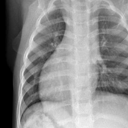

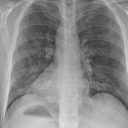

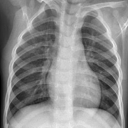

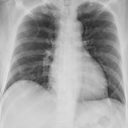

In [27]:
train_batch = minibatchAB(train_A, train_B, 1)

_, A, B = next(train_batch)
display_image(A)
display_image(B)
_, A, B = next(train_batch)   
display_image(A)
display_image(B)
del train_batch, A, B

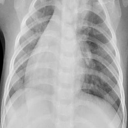

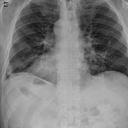

In [28]:
val_batch = minibatchAB(val_A, val_B, 1)

_, A, B = next(val_batch)
display_image(A)
display_image(B)
del val_batch, A, B

In [29]:
def get_output(netG_alpha, netG_beta, X):
    real_input = X
    fake_output = netG_alpha.predict(real_input)
    rec_input = netG_beta.predict(fake_output)
    outputs = [fake_output, rec_input]
    return outputs

In [30]:
def get_combined_output(netG_alpha, netG_beta, X):
    r = [get_output(netG_alpha, netG_beta, X[i:i+1]) for i in range(X.shape[0])]
    r = np.array(r)
    return r.swapaxes(0,1)[:,:,0]  

In [31]:
def show_generator_image(A,B, netG_alpha,  netG_beta):
    assert A.shape==B.shape
      
    rA = get_combined_output(netG_alpha, netG_beta, A)
    rB = get_combined_output(netG_beta, netG_alpha, B)
    
    arr = np.concatenate([A,B,rA[0],rB[0],rA[1],rB[1]])    
    display_image(arr, 3)

In [32]:
def get_generater_function(netG):
    real_input = netG.inputs[0]
    fake_output = netG.outputs[0]
    function = K.function([real_input, K.learning_phase()], [fake_output])
    return function

netG_A_function = get_generater_function(netG_A)
netG_B_function = get_generater_function(netG_B)

In [33]:
class ImagePool():
    def __init__(self, pool_size=200):
        self.pool_size = pool_size
        if self.pool_size > 0:
            self.num_imgs = 0
            self.images = []

    def query(self, images):
        if self.pool_size == 0:
            return images
        return_images = []
        for image in images:
            if self.num_imgs < self.pool_size:
                self.num_imgs = self.num_imgs + 1
                self.images.append(image)
                return_images.append(image)
            else:
                p = uniform(0, 1)
                if p > 0.5:
                    random_id = randint(0, self.pool_size-1)
                    tmp = self.images[random_id]
                    self.images[random_id] = image
                    return_images.append(tmp)
                else:
                    return_images.append(image)
        return_images = np.stack(return_images, axis=0)
        return return_images

In [34]:
K.learning_phase()

<tf.Tensor 'learning_phase:0' shape=() dtype=int32>

In [ ]:
import time
from IPython.display import clear_output
# tf.experimental.output_all_intermediates(True)
# from options.train_options import TrainOptions
# opt = TrainOptions().parse()
# batch_size = 4
time_start = time.time()
how_many_epochs = 20000
iteration_count = 0
epoch_count = 0
display_freq = 30 
save_freq = 300
val_batch = minibatchAB(val_A, val_B, batch_size=4)
_, val_A, val_B = next(val_batch)
train_batch = minibatchAB(train_A, train_B, batch_size)
    
fake_A_pool = ImagePool()
fake_B_pool = ImagePool()

while epoch_count < how_many_epochs: 
    target_label = np.zeros((batch_size, 1))
    epoch_count, A, B = next(train_batch)

    tmp_fake_B = netG_A_function([A, 1])[0]
    tmp_fake_A = netG_B_function([B, 1])[0]
    
    _fake_B = fake_B_pool.query(tmp_fake_B)
    _fake_A = fake_A_pool.query(tmp_fake_A)

    netG_train_function.train_on_batch([A, B], target_label)
    
    netD_B_train_function.train_on_batch([B, _fake_B], target_label)
    netD_A_train_function.train_on_batch([A, _fake_A], target_label)
    
    iteration_count+=1
    
    save_name = dpath + '{}' + str(iteration_count) + '.h5'
    
    if iteration_count%display_freq == 0:
        clear_output()
        timecost =  (time.time()-time_start)/60
        print('epoch_count: {}  iter_count: {}  timecost: {}mins'.format(epoch_count, iteration_count, timecost))
        show_generator_image(val_A,val_B, netG_A, netG_B)
        

    if iteration_count%save_freq == 0:
        netG_A.save_weights(save_name.format('tf_GA_weights'))
        netG_B.save_weights(save_name.format('tf_GB_weights'))
        netD_A.save_weights(save_name.format('tf_DA_weights'))
        netD_B.save_weights(save_name.format('tf_DB_weights'))
        netG_train_function.save_weights(save_name.format('tf_G_train_weights'))
        netD_A_train_function.save_weights(save_name.format('tf_D_A_train_weights'))
        netD_B_train_function.save_weights(save_name.format('tf_D_B_train_weights'))

C:\MySoftware\Anaconda\envs\py36\lib\site-packages\keras\engine\training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


In [ ]:
# inference

In [35]:
load_name = dpath + '{}' + '152100.h5' #152100 150000 151800 152400
netG_A.load_weights(load_name.format('tf_GA_weights'))
netG_B.load_weights(load_name.format('tf_GB_weights'))
netD_A.load_weights(load_name.format('tf_DA_weights'))
netD_B.load_weights(load_name.format('tf_DB_weights'))
netG_train_function.load_weights(load_name.format('tf_G_train_weights'))
netD_A_train_function.load_weights(load_name.format('tf_D_A_train_weights'))
netD_B_train_function.load_weights(load_name.format('tf_D_B_train_weights'))

In [49]:
val_batch = minibatchAB(val_A, val_B, batch_size=1)

In [37]:
# run batch normalization layer in training mode

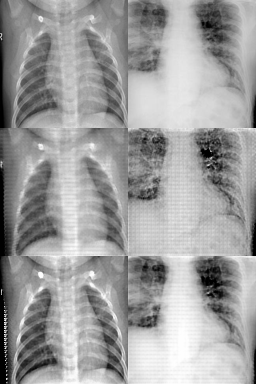

In [84]:
_,A, B = next(val_batch)
show_generator_image(A,B, netG_A, netG_B)

# The Code for generating Images

Commented.

Added for generating the Augmentations. 

Kept for other users.

In [38]:
# countImage=0
#save the image by time
# def display_imagec(X, rows=1):
# #     countImage=countImage+1
#     assert X.shape[0]%rows == 0
#     int_X = ((X*127.5+127.5).clip(0,255).astype('uint8'))
#     int_X = int_X.reshape(-1,image_size,image_size, 3)
#     int_X = int_X.reshape(rows, -1, image_size, image_size,3).swapaxes(1,2).reshape(rows*image_size,-1, 3)
#     pil_X = Image.fromarray(int_X[:,:,0])
#     t = str(time.time())
#     pil_X.save(dpath+'results/'+ t, 'JPEG')
#     display(pil_X)

In [2]:
# val_A=np.array(val_A)
# for i in range(1):
#     _,A, B = next(val_batch)
#     display_imagec(A)
#     rA = [get_output(netG_A, netG_B, A)]
#     rA = np.array(rA)
#     rA = rA.swapaxes(0,1)[:,:,0]
#     display_imagec(rA[0])
#     display_imagec(rA[1])


In [3]:
# for i in range(1):
#     _,A, B = next(val_batch)
#     rB = [get_output(netG_B, netG_A, B)]
#     rB = np.array(rB)
#     rB = rB.swapaxes(0,1)[:,:,0]
# #     display_imagec(rB[0])
#     display_imagec(rB[1])